In [1]:
import os
import sys
import pathlib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

sys.path.append("../src")

from utils.io import load_pickle
from utils.feature import load_feature

pd.set_option('display.max_rows', 5000)


%matplotlib inline

plt.style.use("seaborn-v0_8")

In [2]:
sys.path.append("../src")

誤差が大きいサンプルの特徴を知りたい

In [3]:
data = pd.read_csv("../data/preprocessed/train.csv")
oof_xgb = load_pickle("../data/model/xgb/seed=42/oof.pkl")


feature_names = [
    "word_count",
    "word_overlap_count",
    "text_length",
    "spell_miss_count",
    "sentence_count",
    "quotes_count",
    "quoted_sentence_count",
    "consecutive_dots_count",
]
features = load_feature("../data/feature", feature_names)
feat_df = pd.DataFrame(features, columns=feature_names)


data[["content_pred", "wording_pred"]] = oof_xgb
data = pd.concat([data, feat_df], axis=1)

In [4]:
data = data.assign(
    content_diff=lambda df: (df["content"] - df["content_pred"]).apply(np.square),
    wording_diff=lambda df: (df["wording"] - df["wording_pred"]).apply(np.square),
)

In [5]:
data.head()

,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text,content,wording,fold,content_pred,...,word_count,word_overlap_count,text_length,spell_miss_count,sentence_count,quotes_count,quoted_sentence_count,consecutive_dots_count,content_diff,wording_diff
0,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,000e8c3c7ddb,The third wave was an experimentto see how peo...,0.205683,0.380538,3,0.079868,...,61,8,346,5,4,0,0,0,0.015829,0.094530
1,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",0020ae56ffbf,They would rub it up with soda to make the sme...,-0.548304,0.506755,2,-0.542400,...,52,8,244,2,3,0,0,0,0.000035,0.716730
2,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,004e978e639e,"In Egypt, there were many occupations and soci...",3.128928,4.231226,1,2.630881,...,235,8,1370,32,13,2,2,0,0.248052,4.660185
3,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,005ab0199905,The highest class was Pharaohs these people we...,-0.210614,-0.471415,1,-1.217378,...,25,7,157,5,5,0,0,0,1.013575,0.354595
4,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,0070c9e7af47,The Third Wave developed rapidly because the ...,3.272894,3.219757,3,2.649312,...,203,8,1225,30,14,4,4,0,0.388855,0.499582


In [6]:
data.groupby("prompt_id")[["content_diff", "wording_diff"]].agg(["mean", "size"])

content_diff       wording_diff      
                  mean  size         mean  size
prompt_id                                      
39c16e        0.149998  2057     0.295320  2057
3b9047        0.224109  2009     0.465014  2009
814d6b        0.216732  1103     0.423676  1103
ebad26        0.189062  1996     0.313265  1996

In [7]:
from metric import mcrmse, rmse


mcrmse(data[["content", "wording"]].to_numpy(), data[["content_pred", "wording_pred"]].to_numpy())

0.5222257984694142

In [8]:
for prompt_id, gdf in data.groupby("prompt_id"):
    print("prompt_id:", prompt_id)
    print("content:", rmse(gdf["content"].to_numpy(), gdf["content_pred"].to_numpy()))
    print("wording:", rmse(gdf["wording"].to_numpy(), gdf["wording_pred"].to_numpy()))
    print(mcrmse(gdf[["content", "wording"]].to_numpy(), gdf[["content_pred", "wording_pred"]].to_numpy()))
    print()

prompt_id: 39c16e
content: 0.387295514689371
wording: 0.5434338602026001
0.4653646874459856

prompt_id: 3b9047
content: 0.4734014367441564
wording: 0.6819196951703216
0.577660565957239

prompt_id: 814d6b
content: 0.4655453443263271
wording: 0.6509043598193127
0.5582248520728199

prompt_id: ebad26
content: 0.43481306824787486
wording: 0.5597005570128202
0.4972568126303475



`814d6b` は他と比べてサンプル数が少ない。 

全体的に `content` の誤差のほうが低い。

`wording` の中でも `814b6b` と `3b9047` の誤差が大きいのが気になる

一旦 content, wording の誤差を俯瞰してみる。

<Axes: xlabel='content_diff', ylabel='wording_diff'>

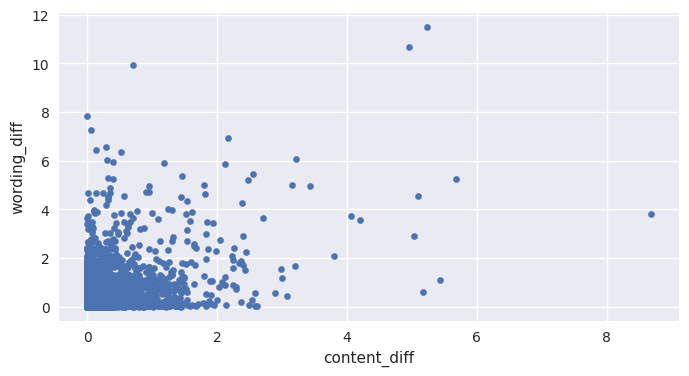

In [9]:
data.plot.scatter(x="content_diff", y="wording_diff", figsize=(8, 4))

prompt_id
39c16e    Axes(0.125,0.11;0.775x0.77)
3b9047    Axes(0.125,0.11;0.775x0.77)
814d6b    Axes(0.125,0.11;0.775x0.77)
ebad26    Axes(0.125,0.11;0.775x0.77)
dtype: object

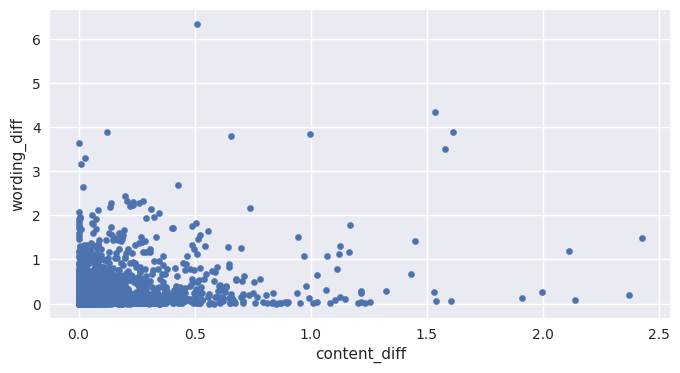

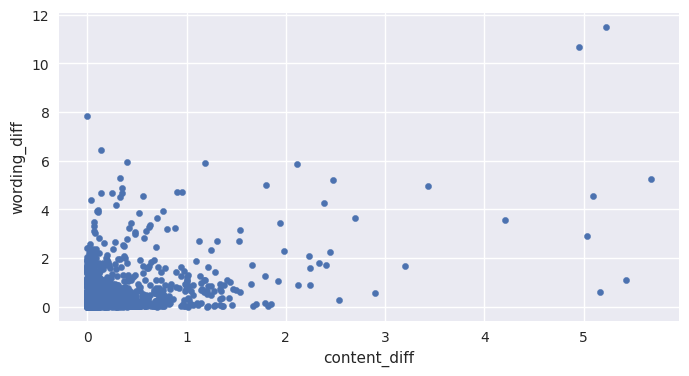

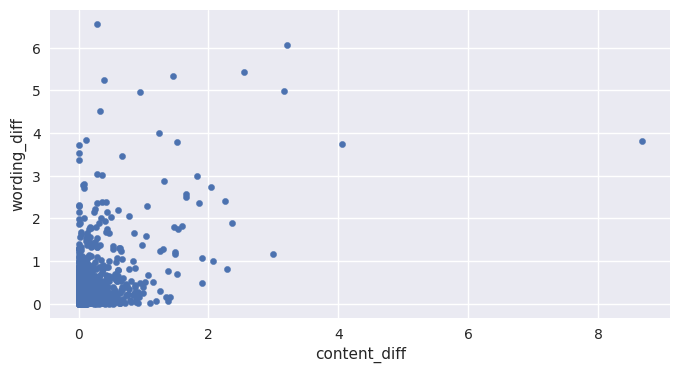

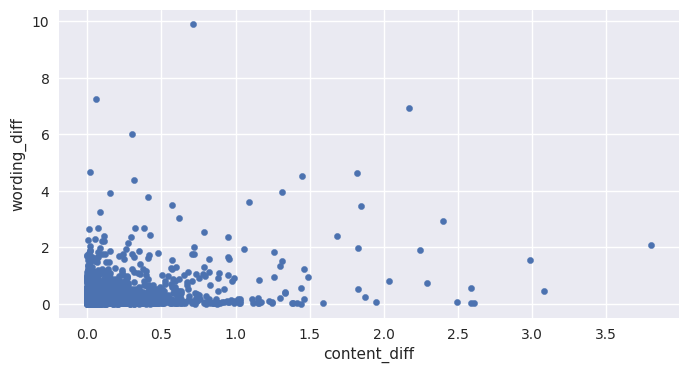

In [10]:
data.groupby("prompt_id").plot.scatter(x="content_diff", y="wording_diff", figsize=(8, 4))

prompt_id
39c16e    Axes(0.125,0.11;0.775x0.77)
3b9047    Axes(0.125,0.11;0.775x0.77)
814d6b    Axes(0.125,0.11;0.775x0.77)
ebad26    Axes(0.125,0.11;0.775x0.77)
Name: content_diff, dtype: object

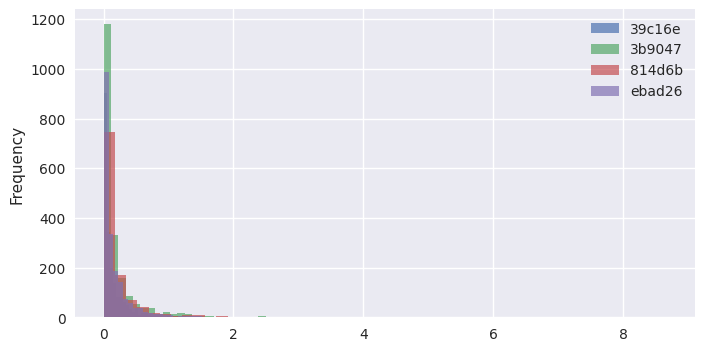

In [11]:
data.groupby("prompt_id")["content_diff"].plot.hist(bins=50, figsize=(8, 4), alpha=0.7, legend=True)

prompt_id
39c16e    Axes(0.125,0.11;0.775x0.77)
3b9047    Axes(0.125,0.11;0.775x0.77)
814d6b    Axes(0.125,0.11;0.775x0.77)
ebad26    Axes(0.125,0.11;0.775x0.77)
Name: wording_diff, dtype: object

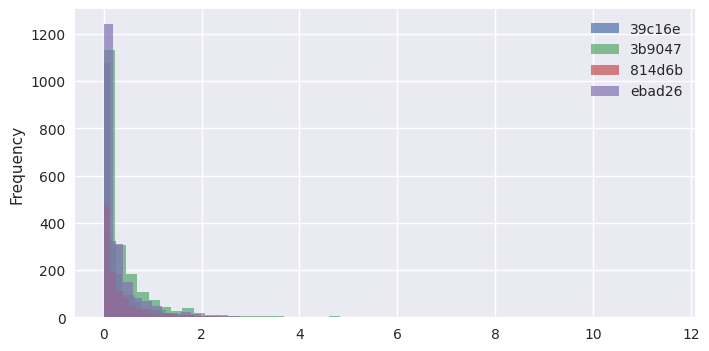

In [12]:
data.groupby("prompt_id")["wording_diff"].plot.hist(bins=50, figsize=(8, 4), alpha=0.7, legend=True)

## `3b9047` の誤差を詳細に見る

In [13]:
tmp = data.query("prompt_id == '3b9047'")

<Axes: xlabel='wording_diff'>

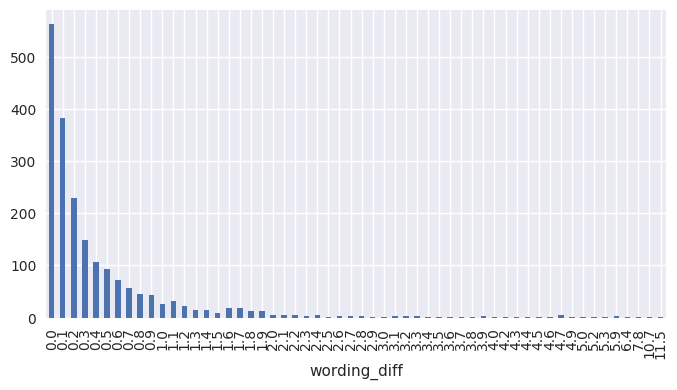

In [14]:
tmp["wording_diff"].round(1).value_counts().sort_index().plot.bar(figsize=(8, 4))

In [15]:
tmp.loc[:, "wording_diff_bin"] = tmp["wording_diff"].round(1)
tmp.groupby("wording_diff_bin")[feature_names].mean()

/tmp/ipykernel_899193/860738255.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.loc[:, "wording_diff_bin"] = tmp["wording_diff"].round(1)


,word_count,word_overlap_count,text_length,spell_miss_count,sentence_count,quotes_count,quoted_sentence_count,consecutive_dots_count
wording_diff_bin,,,,,,,,
0.0,74.882562,7.937722,433.462633,10.969751,5.761566,0.314947,0.571174,0.033808
0.1,75.005222,7.963446,438.396867,10.979112,5.882507,0.287206,0.503916,0.036554
0.2,75.817391,7.960870,441.786957,11.165217,5.952174,0.265217,0.600000,0.043478
0.3,86.657718,7.946309,505.926174,13.181208,6.503356,0.469799,0.892617,0.033557
0.4,78.457944,7.981308,458.457944,11.906542,6.009346,0.317757,0.663551,0.018692
0.5,82.968085,7.989362,488.202128,12.457447,6.212766,0.329787,0.617021,0.021277
0.6,77.152778,7.958333,449.680556,10.847222,5.791667,0.347222,0.472222,0.000000
0.7,85.214286,8.000000,497.964286,12.285714,7.017857,0.446429,0.696429,0.035714
0.8,82.688889,8.000000,483.577778,12.177778,6.333333,0.288889,0.577778,0.000000


## `814d6b` の誤差を詳細に見る

<Axes: xlabel='wording_diff'>

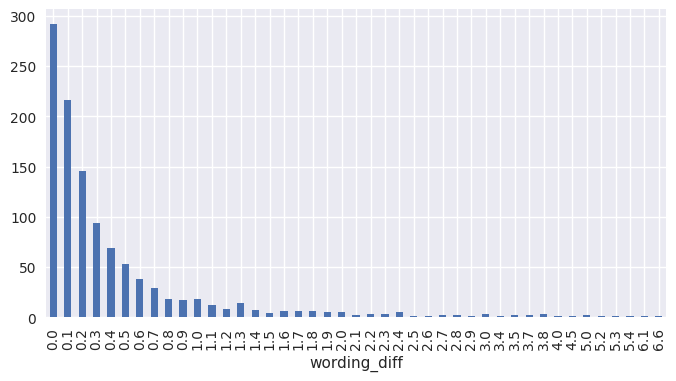

In [16]:
tmp = data.query("prompt_id == '814d6b'")

tmp["wording_diff"].round(1).value_counts().sort_index().plot.bar(figsize=(8, 4))

In [17]:
tmp.loc[:, "wording_diff_bin"] = tmp["wording_diff"].round(1)
tmp.groupby("wording_diff_bin")[feature_names].mean()

/tmp/ipykernel_899193/860738255.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.loc[:, "wording_diff_bin"] = tmp["wording_diff"].round(1)


,word_count,word_overlap_count,text_length,spell_miss_count,sentence_count,quotes_count,quoted_sentence_count,consecutive_dots_count
wording_diff_bin,,,,,,,,
0.0,65.020548,7.910959,366.684932,6.626712,4.243151,0.116438,0.287671,0.037671
0.1,65.458333,7.893519,366.578704,6.194444,4.134259,0.097222,0.194444,0.027778
0.2,65.842466,7.924658,370.493151,6.753425,4.445205,0.171233,0.260274,0.013699
0.3,67.861702,7.914894,380.553191,6.829787,4.468085,0.148936,0.276596,0.021277
0.4,67.956522,7.942029,384.014493,6.811594,4.623188,0.101449,0.318841,0.101449
0.5,84.396226,7.905660,475.566038,8.377358,5.207547,0.283019,0.452830,0.000000
0.6,81.263158,7.973684,457.263158,7.631579,4.921053,0.157895,0.263158,0.000000
0.7,66.379310,7.931034,377.275862,6.103448,4.241379,0.137931,0.241379,0.000000
0.8,82.666667,8.000000,468.888889,8.444444,5.222222,0.111111,0.333333,0.055556


`word_count` が大きいほど誤差が大きいのが特徴的。

例外はある。前半に予測に寄与する単語が入ってるとかなのか？binごとのサンプルは少ないだろうから分散はそれなりにありそう。

他のprompt_idのも見てみる。

In [18]:
data.loc[:, "wording_diff_bin"] = data["wording_diff"].round(1)
data.groupby(["prompt_id", "wording_diff_bin"])[feature_names].mean()

word_count  word_overlap_count  text_length  \
prompt_id wording_diff_bin                                                
39c16e    0.0                56.030702            7.980994   313.564327   
          0.1                58.412134            7.987448   326.765690   
          0.2                59.668122            7.982533   334.026201   
          0.3                65.240260            7.974026   362.701299   
          0.4                68.113402            7.989691   383.000000   
          0.5                69.777778            8.000000   394.986111   
          0.6                65.672131            7.950820   368.131148   
          0.7                64.769231            7.980769   368.076923   
          0.8                83.888889            8.000000   477.138889   
          0.9                70.516129            8.000000   386.322581   
          1.0                64.727273            7.954545   362.000000   
          1.1                88.227273            8.000000   498.590909   
          1.2                97.826087            8.000000   544.826087   
          1.3                76.700000            8.000000   433.450000   
          1.4                86.111111            8.000000   470.000000   
          1.5                87.307692            7.923077   492.769231   
          1.6                92.142857            8.000000   515.142857   
          1.7                75.000000            8.000000   415.857143   
          1.8                83.500000            8.000000   477.333333   
          1.9                55.200000            8.000000   304.200000   
          2.0                74.666667            8.000000   400.666667   
          2.1                88.500000            8.000000   506.000000   
          2.2                97.250000            7.750000   546.250000   
          2.3                73.400000            8.000000   430.800000   
          2.4               109.000000            8.000000   628.000000   
          2.6                42.000000            8.000000   259.000000   
          2.7                63.000000            8.000000   297.000000   
          3.2                87.000000            8.000000   479.000000   
          3.3               130.000000            8.000000   750.000000   
          3.5               304.000000            8.000000  1759.000000   
          3.6                85.000000            8.000000   490.000000   
          3.8               372.000000            8.000000  2166.000000   
          3.9               191.000000            8.000000  1111.000000   
          4.3               152.000000            8.000000   734.000000   
          6.4               641.000000            8.000000  3711.000000   
3b9047    0.0                74.882562            7.937722   433.462633   
          0.1                75.005222            7.963446   438.396867   
          0.2                75.817391            7.960870   441.786957   
          0.3                86.657718            7.946309   505.926174   
          0.4                78.457944            7.981308   458.457944   
          0.5                82.968085            7.989362   488.202128   
          0.6                77.152778            7.958333   449.680556   
          0.7                85.214286            8.000000   497.964286   
          0.8                82.688889            8.000000   483.577778   
          0.9                97.477273            7.931818   571.045455   
          1.0                95.000000            8.000000   557.222222   
          1.1               105.375000            7.937500   621.781250   
          1.2                72.409091            8.000000   435.454545   
          1.3               157.533333            8.000000   919.733333   
          1.4               107.466667            8.000000   642.933333   
          1.5               109.444444            8.000000   663.000000   
          1.6               100.631579            8.0

他のprompt_idも同様の傾向が見られる。

`wording` とある通り、実際には全文目を通してスコアをつけているから後半の部分が無視されている可能性が高い。


対策として、contentはprompt_text+summary text とし、wordingはsummary textのみとするのはどうだろうか。

`content` も見てみる。

In [19]:
data.loc[:, "content_diff_bin"] = data["content_diff"].round(1)
data.groupby(["prompt_id", "content_diff_bin"])[feature_names].mean()

word_count  word_overlap_count  text_length  \
prompt_id content_diff_bin                                                
39c16e    0.0                56.624315            7.984666   316.587076   
          0.1                58.739372            7.987061   328.648799   
          0.2                64.660550            7.986239   362.133028   
          0.3                70.703448            7.986207   396.089655   
          0.4                64.723684            7.973684   358.342105   
          0.5               108.018868            7.981132   611.396226   
          0.6                67.233333            7.966667   378.266667   
          0.7                98.772727            7.909091   567.590909   
          0.8                84.000000            7.909091   477.909091   
          0.9                74.625000            8.000000   423.000000   
          1.0                85.750000            7.875000   497.250000   
          1.1                91.444444            8.000000   521.333333   
          1.2               151.571429            8.000000   883.142857   
          1.3                58.500000            8.000000   322.500000   
          1.4               261.000000            8.000000  1505.000000   
          1.5                90.250000            7.750000   483.000000   
          1.6               229.333333            8.000000  1311.666667   
          1.9                59.000000            8.000000   310.000000   
          2.0               302.000000            8.000000  1742.000000   
          2.1               209.000000            8.000000  1188.000000   
          2.4               146.000000            8.000000   812.000000   
3b9047    0.0                76.050569            7.957016   441.883692   
          0.1                76.916201            7.957169   447.752328   
          0.2                88.058559            7.972973   516.545045   
          0.3                86.000000            7.954545   506.848485   
          0.4               108.440000            7.986667   643.053333   
          0.5               103.355556            7.977778   620.666667   
          0.6               110.205128            7.948718   655.974359   
          0.7                82.393939            7.939394   484.606061   
          0.8                99.809524            7.904762   582.047619   
          0.9               108.888889            8.000000   658.222222   
          1.0               107.095238            7.952381   634.714286   
          1.1                80.818182            8.000000   469.454545   
          1.2               107.384615            8.000000   645.000000   
          1.3               109.833333            8.000000   638.750000   
          1.4               105.142857            8.000000   639.285714   
          1.5               102.500000            8.000000   633.500000   
          1.6                47.000000            8.000000   316.000000   
          1.7               118.333333            8.000000   708.333333   
          1.8               231.000000            8.000000  1302.000000   
          1.9               107.333333            8.000000   660.333333   
          2.0               113.000000            8.000000   678.000000   
          2.1               103.500000            8.000000   597.000000   
          2.2               112.666667            8.000000   694.666667   
          2.3               211.000000            8.000000  1234.000000   
          2.4               125.333333            8.000000   767.000000   
          2.5               112.500000            8.000000   671.000000   
          2.7                92.000000            8.000000   568.000000   
          2.9                82.000000            8.000000   484.000000   
          3.2               179.000000            8.000000  1039.000000   
          3.4               261.000000            8.000000  1595.000000   
          4.2               160.000000            8.0

debertaが観測できていない単語や単語ごとの特徴量をもっと加える方向性を探ってみる。

あとはprompt questionに対しての異なる表現でのうまい言い回しをしていたりすると評価が高いかもしれない。

## Feature idea

- 単語の長さの最大、平均、中央
- debertaのmax_lenを1024などの512以上の値にする